# Hamiltonian

The full Hamiltonian is of form:

$\begin{equation}H = \Delta_{pc} \sum^2_{i=1} a_i^{\dagger} a_i - \frac{\Delta_{pa}}{2} \sum^1_{i=0} \ket{i}\bra{i} + \frac{\Delta_{pa}}{2} \sum^5_{i=2} \ket{i}\bra{i}+ [\frac{\Omega}{2}(\ket{3}\bra{0} + \ket{4}\bra{1}) + \text{h.c.}] + \{g\{[(\frac{\ket{2} + \ket{4}}{\sqrt{2}})\bra{0}] + [(\frac{\ket{3} + \ket{5}}{\sqrt{2}})\bra{1}]\}a_1 + \text{h.c.}\} + \{g(\ket{0}\bra{3} + \ket{1}\bra{4})a_2 + \text{h.c.}\}\end{equation}$

and our jump operators are of form
$
\begin{align}
L_i &= \sqrt{2\gamma} \sigma_i^- \\
L_c &= \sqrt{2\kappa} a
\end{align}
$

In [2]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from tqdm import tqdm
from qutip.ui.progressbar import BaseProgressBar, TextProgressBar

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [16]:
# params
g = 2 * np.pi * 3.1 # coupling amplitude
gamma = 2 * np.pi * 3.0 # atom decay, MHz
kappa =  2 * np.pi * 0.53 # MHz 

# mid circuit measurement paper
Delta_pa = - 2 * np.pi * 80 # probe atom detuning (MHz), we'll put in magic detuning for now
Delta_pc = 2 * np.pi * 0 # probe cavity detuning (MHz) (we can be on resonance for this)
Omega = 2 * np.pi * 13 # probe Rabi frequency (MHz)

In [17]:
# basis states
basis_states = [qt.basis(6, i) for i in range(6)]

# atomic and cavity operators
sigma_plus = [basis_states[i] * basis_states[i+1].dag() for i in range(5)]
sigma_minus = [op.dag() for op in sigma_plus]

num_fock = 5
a1 = qt.tensor(qt.qeye(6), qt.destroy(num_fock), qt.qeye(num_fock))
a2 = qt.tensor(qt.qeye(6), qt.qeye(num_fock), qt.destroy(num_fock))

$H = \Delta_{pc} \sum^2_{i=1} a_i^{\dagger} a_i$

$ -\frac{\Delta_{pa}}{2} (\ket{0}\bra{0} + \ket{1}\bra{1})$ 

$ +\frac{\Delta_{pa}}{2} (\ket{2}\bra{2} + \ket{3}\bra{3}+ \ket{4}\bra{4}+ \ket{5}\bra{5})$ 

$+ \frac{\Omega}{2}(\ket{3}\bra{0} + \ket{4}\bra{1}) + \text{h.c.}$

$+ g\{[(\frac{\ket{2} + \ket{4}}{\sqrt{2}})\bra{0}] + [(\frac{\ket{3} + \ket{5}}{\sqrt{2}})\bra{1}]\}a_1 + \text{h.c.} $

$+g(\ket{0}\bra{3} + \ket{1}\bra{4})a_2 + \text{h.c.}$

I'll break up the Hamiltonian a bit for readability

In [18]:
H_cavity = Delta_pc * (a1.dag() * a1 + a2.dag() * a2)

H_atomic = Delta_pa * qt.tensor(sum([basis_states[i] * basis_states[i].dag() for i in range(6)]), qt.qeye(5), qt.qeye(5))

H_drive = (Omega/2) * (
    qt.tensor(sigma_plus[3], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_plus[4], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_minus[3], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_minus[4], qt.qeye(5), qt.qeye(5))
)

H_interaction_1 = g * (
    qt.tensor((basis_states[2] + basis_states[4])/np.sqrt(2) * basis_states[0].dag(), qt.destroy(5), qt.qeye(5)) +
    qt.tensor((basis_states[3] + basis_states[5])/np.sqrt(2) * basis_states[1].dag(), qt.destroy(5), qt.qeye(5)) +
    qt.tensor(basis_states[0] * basis_states[3].dag() + basis_states[1] * basis_states[4].dag(), qt.qeye(5), qt.destroy(5))
)

H_interaction_2 = g * (
    qt.tensor((basis_states[2] + basis_states[4])/np.sqrt(2) * basis_states[0].dag(), qt.destroy(5), qt.qeye(5)).dag() +
    qt.tensor((basis_states[3] + basis_states[5])/np.sqrt(2) * basis_states[1].dag(), qt.destroy(5), qt.qeye(5)).dag() +
    qt.tensor(basis_states[0] * basis_states[3].dag() + basis_states[1] * basis_states[4].dag(), qt.qeye(5), qt.destroy(5)).dag()
)

H = H_cavity + H_atomic + H_drive + H_interaction_1 + H_interaction_2

Quantum object: dims = [[6, 5, 5], [6, 5, 5]], shape = (150, 150), type = oper, isherm = True
Qobj data =
[[-502.65482457    0.            0.         ...    0.
     0.            0.        ]
 [   0.         -502.65482457    0.         ...    0.
     0.            0.        ]
 [   0.            0.         -502.65482457 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ... -502.65482457
     0.            0.        ]
 [   0.            0.            0.         ...    0.
  -502.65482457    0.        ]
 [   0.            0.            0.         ...    0.
     0.         -502.65482457]]


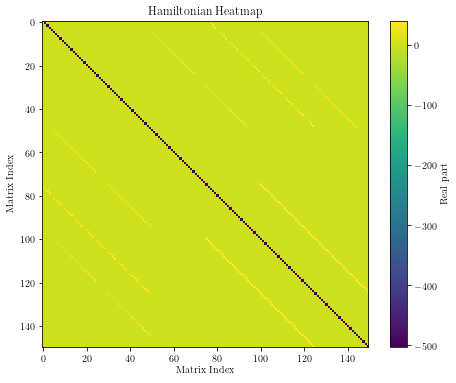

In [19]:
H_matrix = H.full()
print(H)

plt.figure(figsize=(8, 6))
plt.title("Hamiltonian Heatmap")
plt.imshow(np.real(H_matrix), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Real part")
plt.xlabel("Matrix Index")
plt.ylabel("Matrix Index")
plt.show()

In [20]:
# jump ops
L_i = [np.sqrt(2 * gamma) * qt.tensor(basis_states[i] * basis_states[i].dag(), qt.qeye(5), qt.qeye(5)) for i in range(6)]
L_c = [np.sqrt(2 * kappa) * a1, np.sqrt(2 * kappa) * a2]

c_ops = L_i + L_c

# expectation values we want to look at
e_ops = [
    qt.tensor(basis_states[i] * basis_states[i].dag(), qt.qeye(5), qt.qeye(5)) for i in range(6)] \
        + [a1.dag() * a1, a2.dag() * a2]

## Time Dynamics

In [28]:
# Initial state and time evo
initial_state = qt.tensor(basis_states[0], qt.basis(5, 0), qt.basis(5, 0))
times = np.linspace(0, 1, 1000)
print("Beginning time dynamics sim")
result = qt.mesolve(H, initial_state, times, c_ops, e_ops, progress_bar=True)

Beginning time dynamics sim
10.0%. Run time:   0.11s. Est. time left: 00:00:00:00
20.0%. Run time:   0.21s. Est. time left: 00:00:00:00
30.0%. Run time:   0.31s. Est. time left: 00:00:00:00
40.0%. Run time:   0.41s. Est. time left: 00:00:00:00
50.0%. Run time:   0.54s. Est. time left: 00:00:00:00
60.0%. Run time:   0.65s. Est. time left: 00:00:00:00
70.0%. Run time:   0.75s. Est. time left: 00:00:00:00
80.0%. Run time:   0.86s. Est. time left: 00:00:00:00
90.0%. Run time:   0.97s. Est. time left: 00:00:00:00
Total run time:   1.07s


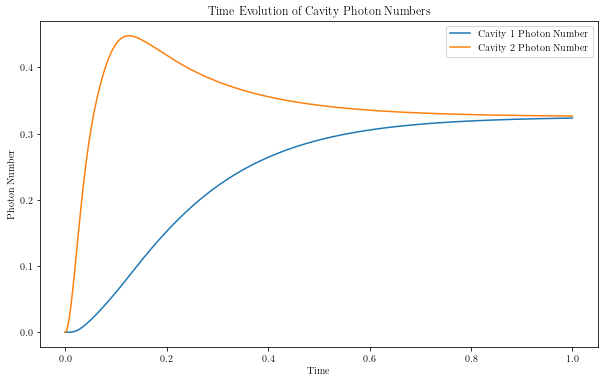

In [29]:
# Plot cavity photon numbers
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(result.times, result.expect[6], label="Cavity 1 Photon Number")
ax.plot(result.times, result.expect[7], label="Cavity 2 Photon Number")

ax.set_xlabel('Time')
ax.set_ylabel('Photon Number')
ax.legend()
plt.show()

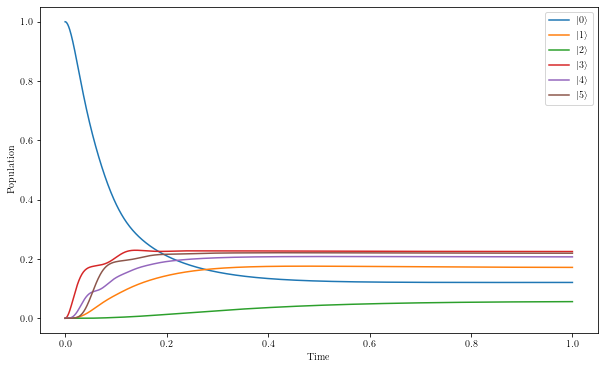

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(6):
    ax.plot(result.times, result.expect[i], label=f"$|{i}\\rangle$")

ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.legend()
plt.show()

## Steady State

In [38]:
rho_ss = qt.steadystate(H, c_ops)

atomic_populations = [qt.expect(qt.tensor(basis_states[i] * basis_states[i].dag(), qt.qeye(5), qt.qeye(5)), rho_ss) for i in range(6)]
cavity_photons = [qt.expect(a1.dag() * a1, rho_ss), qt.expect(a2.dag() * a2, rho_ss)]


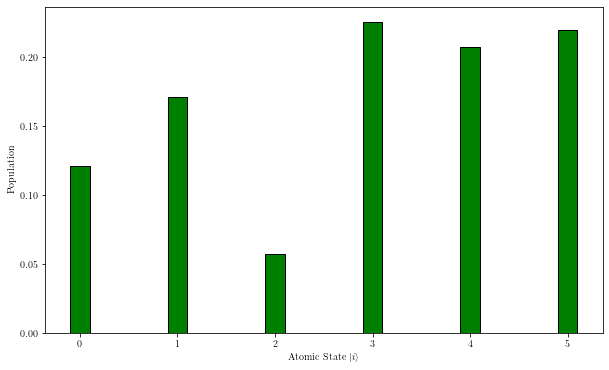

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# add outlines
ax.bar(range(6), atomic_populations, width=0.2, color='g', edgecolor='k')
ax.set_xlabel('Atomic State $|i\\rangle$')
ax.set_ylabel('Population')
plt.show()

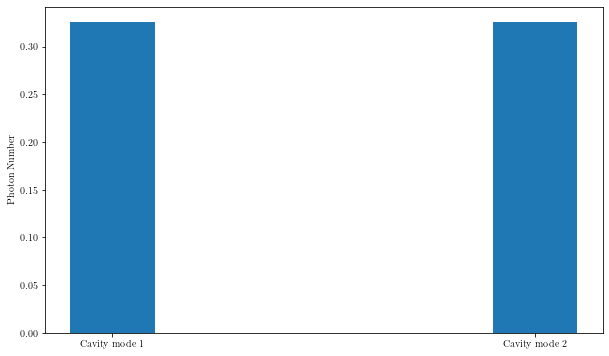

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.bar(["Cavity mode 1", "Cavity mode 2"], cavity_photons, width = 0.2)
ax.set_ylabel('Photon Number')
plt.show()

## Sanity Checks

In [55]:
# let's check that for g = 0 we don't see any cavity photons
H_cavity = Delta_pc * (a1.dag() * a1 + a2.dag() * a2)

H_atomic = Delta_pa * qt.tensor(sum([basis_states[i] * basis_states[i].dag() for i in range(6)]), qt.qeye(5), qt.qeye(5))

H_drive = (Omega/2) * (
    qt.tensor(sigma_plus[3], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_plus[4], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_minus[3], qt.qeye(5), qt.qeye(5)) +
    qt.tensor(sigma_minus[4], qt.qeye(5), qt.qeye(5))
)

H = H_cavity + H_atomic + H_drive

# jump ops
L_i = [np.sqrt(2 * gamma) * qt.tensor(basis_states[i] * basis_states[i].dag(), qt.qeye(5), qt.qeye(5)) for i in range(6)]
L_c = [np.sqrt(2 * kappa) * a1, np.sqrt(2 * kappa) * a2]

c_ops = L_i + L_c

# expectation values we want to look at
e_ops = [
    qt.tensor(basis_states[i] * basis_states[i].dag(), qt.qeye(5), qt.qeye(5)) for i in range(6)] \
        + [a1.dag() * a1, a2.dag() * a2]
        
# Initial state and time evo
initial_state = qt.tensor(basis_states[0], qt.basis(5, 0), qt.basis(5, 0))
times = np.linspace(0, 1, 1000)
print("Beginning time dynamics sim")
result = qt.mesolve(H, initial_state, times, c_ops, e_ops, progress_bar=True)

Beginning time dynamics sim
10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.03s. Est. time left: 00:00:00:00
40.0%. Run time:   0.04s. Est. time left: 00:00:00:00
50.0%. Run time:   0.05s. Est. time left: 00:00:00:00
60.0%. Run time:   0.06s. Est. time left: 00:00:00:00
70.0%. Run time:   0.07s. Est. time left: 00:00:00:00
80.0%. Run time:   0.08s. Est. time left: 00:00:00:00
90.0%. Run time:   0.09s. Est. time left: 00:00:00:00
Total run time:   0.10s


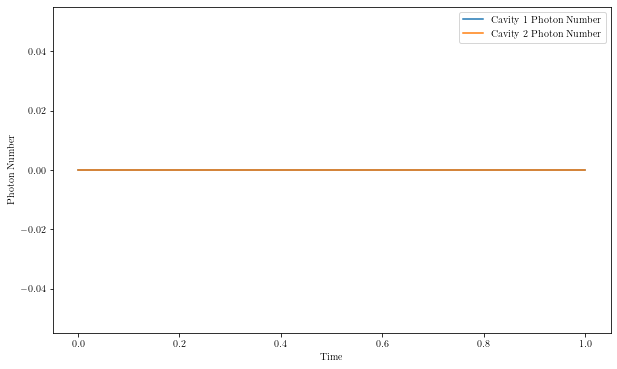

In [56]:
# Plot cavity photon numbers
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(result.times, result.expect[6], label="Cavity 1 Photon Number")
ax.plot(result.times, result.expect[7], label="Cavity 2 Photon Number")

ax.set_xlabel('Time')
ax.set_ylabel('Photon Number')
ax.legend()
plt.show()

looks good on that front. Let's also check that without drive we have no atomic population transfer

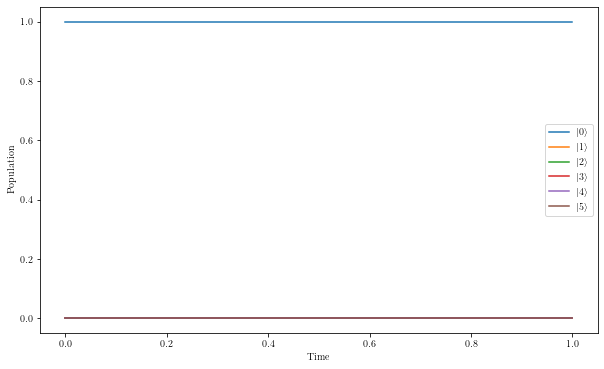

In [57]:
# let's check that for g = 0 we don't see any cavity photons
H_cavity = Delta_pc * (a1.dag() * a1 + a2.dag() * a2)

H_atomic = Delta_pa * qt.tensor(sum([basis_states[i] * basis_states[i].dag() for i in range(6)]), qt.qeye(5), qt.qeye(5))

H_interaction_1 = g * (
    qt.tensor((basis_states[2] + basis_states[4])/np.sqrt(2) * basis_states[0].dag(), qt.destroy(5), qt.qeye(5)) +
    qt.tensor((basis_states[3] + basis_states[5])/np.sqrt(2) * basis_states[1].dag(), qt.destroy(5), qt.qeye(5)) +
    qt.tensor(basis_states[0] * basis_states[3].dag() + basis_states[1] * basis_states[4].dag(), qt.qeye(5), qt.destroy(5))
)

H_interaction_2 = g * (
    qt.tensor((basis_states[2] + basis_states[4])/np.sqrt(2) * basis_states[0].dag(), qt.destroy(5), qt.qeye(5)).dag() +
    qt.tensor((basis_states[3] + basis_states[5])/np.sqrt(2) * basis_states[1].dag(), qt.destroy(5), qt.qeye(5)).dag() +
    qt.tensor(basis_states[0] * basis_states[3].dag() + basis_states[1] * basis_states[4].dag(), qt.qeye(5), qt.destroy(5)).dag()
)

H = H_cavity + H_atomic + H_interaction_1 + H_interaction_2

# jump ops
L_i = [np.sqrt(2 * gamma) * qt.tensor(basis_states[i] * basis_states[i].dag(), qt.qeye(5), qt.qeye(5)) for i in range(6)]
L_c = [np.sqrt(2 * kappa) * a1, np.sqrt(2 * kappa) * a2]

c_ops = L_i + L_c

# expectation values we want to look at
e_ops = [
    qt.tensor(basis_states[i] * basis_states[i].dag(), qt.qeye(5), qt.qeye(5)) for i in range(6)] \
        + [a1.dag() * a1, a2.dag() * a2]
        
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for i in range(6):
    ax.plot(result.times, result.expect[i], label=f"$|{i}\\rangle$")

ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.legend()
plt.show()